In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
from scipy.stats import chisquare
from scipy import stats as st
import arviz as az
import csv
from tqdm import tqdm
from matplotlib.patches import ConnectionPatch
from scipy import stats as st
import pymc as pm

In [4]:
core_shift_fn = np.poly1d([140.6, -2.882])
print(core_shift_fn)

 
140.6 x - 2.882


In [5]:
def getOffset(freq):
    r = -0.01 + 161.37*freq**(-1.16)
    return r

In [6]:
def getNoise(data):
    """
    get the noise in the image
    """
    tmp = np.copy(data)
    tmp[np.abs(tmp) > 3*np.std(tmp)] = 0
    tmp[np.abs(tmp) > 3*np.std(tmp)] = 0
    return np.std(tmp)

def checkIfFlagged(input_band, input_IF):
    with open("epoch1//flaglist.csv") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        for row in csv_reader:
            band, IF = row
            if band == 'band' and IF == ' IF':
                continue
            
            elif input_band == int(band) and input_IF == int(IF):
                return True
            
    return False

In [7]:
cube = []
noise_array = []
freq_array = []

## get ref freq
hdu = fits.open('epoch1//band{}/SEDI-IF-{}.fits'.format(11, 8))
freq0 = float(hdu[0].header['CRVAL3'])/1e9

for band in tqdm(np.arange(11, -1, -1)):
    
    for IF in np.arange(8, 0, -1):
        
        ## check if flagged
        if checkIfFlagged(band, IF):
            continue
            
        hdu = fits.open('epoch1/band{}/SEDI-IF-{}.fits'.format(band, IF))
        data = hdu[0].data[0,0,:,:]
        noise = getNoise(data)
        freq = float(hdu[0].header['CRVAL3'])/1e9
        
        ## rotate image
        dataRotated = rotate(data, -90 + 48, order=5, reshape=False)
        
        ## apply coreshift
        #core_shift = core_shift_fn(1/(freq0)) - core_shift_fn(1/(freq))
        core_shift = getOffset(freq0)- getOffset(freq) 
        data_coreshifted = np.roll(np.copy(dataRotated), int(core_shift/0.2), axis=1)
        
        cube.append(data_coreshifted)
        freq_array.append(freq)
        noise_array.append(noise)
        

100%|███████████████████████████████████████████| 12/12 [00:22<00:00,  1.86s/it]


In [8]:
cube = np.array(cube)
noise_array = np.array(noise_array)
freq_array = np.array(freq_array)


In [9]:
def plot(ax, epoch, color):
    ### load data
    output_col = np.load('epoch{}/ouput_colMCMC.npy'.format(epoch))
    output_sed = np.load('epoch{}/output_sedMCMC.npy'.format(epoch))
    output_sed_upper = np.load('epoch{}/output_sed_upperMCMC.npy'.format(epoch))
    output_sed_lower = np.load('epoch{}/output_sed_lowerMCMC.npy'.format(epoch))
    
    ax.plot((np.array(output_col) - 512)*-1*0.2, output_sed, color=color, linestyle='dashed', label='epoch {}'.format(epoch))

    ax.fill_between((np.array(output_col) - 512)*-1*0.2, output_sed_upper, output_sed_lower, color=color, alpha=0.3)

    return 


def getFlux(distance, epoch):
    col = int(512 - distance/0.2)
    row = 512
    threshold = 10
    
    light_array = cube[:, row, col]
    snr_array = light_array/noise_array
    mask = snr_array >= threshold

    masked_light = light_array[mask]
    masked_freq = freq_array[mask]
    masked_noise = noise_array[mask]
    masked_light_err = np.sqrt((0.1*masked_light)**2 + (masked_noise)**2)

    return masked_freq, masked_light, masked_light_err


/tmp/ipykernel_4105762/3745411749.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, a, s]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipykernel_4105762/3745411749.py:74: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
/tmp/ipykernel_4105762/3745411749.py:84: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, a, s]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipykernel_4105762/3745411749.py:119: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, a, s]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_4105762/3745411749.py:162: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, a, s]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipykernel_4105762/3745411749.py:206: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, a, s]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
/tmp/ipykernel_4105762/3745411749.py:250: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, a, s]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_4105762/3745411749.py:294: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font fa

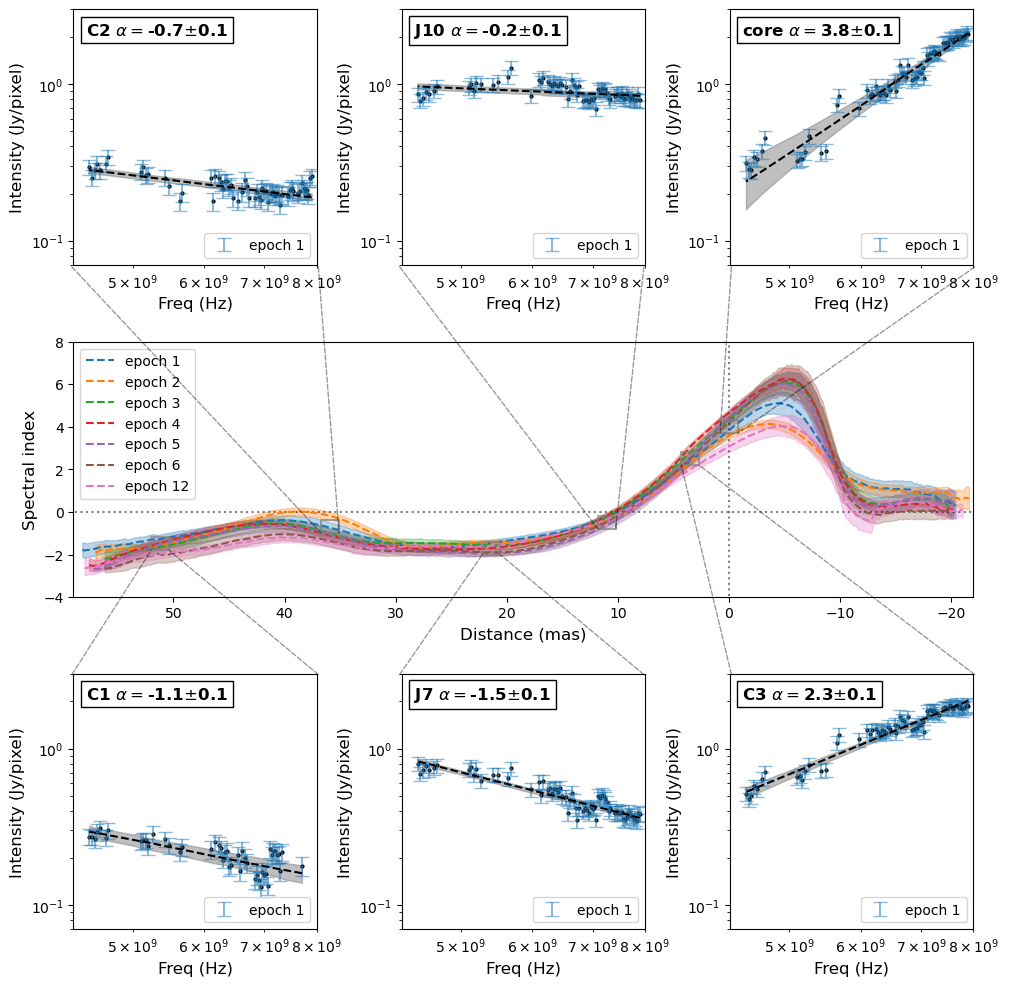

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=False)
hfont = {'fontname':'Helvetica', 'size':12}


ax[1].set_xlim(59, -22)
ax[1].set_ylim(-4, 8)
ax[1].vlines(0,-5,12, color='black', linestyle='dotted', alpha=0.5)
ax[1].hlines(0,-50,120, color='black', linestyle='dotted', alpha=0.5)


ax[1].set_xlabel('Distance (mas)', **hfont)
ax[1].set_ylabel('Spectral index', **hfont)

color = '#1f77b4'
plot(ax[1], 1, color)

color = '#ff7f0e'
plot(ax[1], 2, color)

color = '#2ca02c'
plot(ax[1], 3, color)

color = '#d62728'
plot(ax[1], 4, color)

color = '#9467bd'
plot(ax[1], 5, color)

color = '#8c564b'
plot(ax[1], 6, color)

color = '#e377c2'
plot(ax[1], 12, color)

ax[1].legend()

defaultBlue = '#1f77b4'


### core
masked_freq, masked_light, masked_light_err = getFlux(0, 1)
plt.subplot(3, 3, 3)
plt.errorbar(masked_freq*1e9, masked_light, yerr=masked_light_err, fmt=' ', capsize=5, color=defaultBlue, alpha=0.5, label='epoch 1')
plt.scatter(masked_freq*1e9, masked_light, s=4, facecolor=defaultBlue, edgecolor='black')
plt.ylim(0.7*0.1, 3)
plt.yscale('log')
plt.legend(loc=4)
plt.xscale('log')

with pm.Model() as model:

    alpha = pm.Uniform('alpha', -8, 8)
    a = pm.Uniform('a', 0, 20)
    s = pm.Uniform('s', 0, 10)

    ## likelyhood
    Y = pm.Normal('Y', mu=a*masked_freq**alpha, sigma=np.sqrt(s**2 + masked_light_err**2), observed=masked_light)
    samp = pm.sample(draws=500, chains=8, cores=8)

stacked_samp = samp.posterior.stack(sample=('chain', 'draw'))
trace = []
core_alpha = np.median(stacked_samp['alpha'][:])
core_alpha_err = np.std(stacked_samp['alpha'][:])

for i in range(500):
    a_tmp = float(stacked_samp['a'][i])
    alpha_tmp = float(stacked_samp['alpha'][i])
    s_tmp = float(stacked_samp['s'][i])

    trace.append(a_tmp*masked_freq**alpha_tmp + s_tmp)
    trace.append(a_tmp*masked_freq**alpha_tmp - s_tmp)


upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
plt.fill_between(masked_freq*1e9, upper_limit, lower_limit, alpha=0.5, color='grey', zorder=-1)

plt.plot(masked_freq*1e9, np.median(trace, axis=0), color='black', linestyle='dashed')
plt.xlabel('Freq (Hz)', **hfont)
plt.ylabel('Intensity (Jy/pixel)', **hfont)
plt.xlim(4.3*1e9, 8*1e9)


## C5
plt.subplot(3, 3, 9)
masked_freq, masked_light, masked_light_err = getFlux(3.5, 1)
plt.errorbar(masked_freq*1e9, masked_light, yerr=masked_light_err, fmt=' ', capsize=5, color=defaultBlue, alpha=0.5, label='epoch 1')
plt.scatter(masked_freq*1e9, masked_light, s=4, facecolor=defaultBlue, edgecolor='black')
plt.ylim(0.7*0.1, 3)
plt.yscale('log')
plt.legend(loc=4)
plt.xscale('log')

with pm.Model() as model:

    alpha = pm.Uniform('alpha', -8, 8)
    a = pm.Uniform('a', 0, 20)
    s = pm.Uniform('s', 0, 10)

    ## likelyhood
    Y = pm.Normal('Y', mu=a*masked_freq**alpha, sigma=np.sqrt(s**2 + masked_light_err**2), observed=masked_light)
    samp = pm.sample(draws=500, chains=8, cores=8)

stacked_samp = samp.posterior.stack(sample=('chain', 'draw'))
trace = []
c5_alpha = np.median(stacked_samp['alpha'][:])
c5_alpha_err = np.std(stacked_samp['alpha'][:])



for i in range(500):
    a_tmp = float(stacked_samp['a'][i])
    alpha_tmp = float(stacked_samp['alpha'][i])
    s_tmp = float(stacked_samp['s'][i])

    trace.append(a_tmp*masked_freq**alpha_tmp + s_tmp)
    trace.append(a_tmp*masked_freq**alpha_tmp - s_tmp)


upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
plt.fill_between(masked_freq*1e9, upper_limit, lower_limit, alpha=0.5, color='grey', zorder=-1)

plt.plot(masked_freq*1e9, np.median(trace, axis=0), color='black', linestyle='dashed')
plt.xlabel('Freq (Hz)', **hfont)
plt.ylabel('Intensity (Jy/pixel)', **hfont)
plt.xlim(4.3*1e9, 8*1e9)


## C4
plt.subplot(3, 3, 2)
masked_freq, masked_light, masked_light_err = getFlux(11, 1)
plt.errorbar(masked_freq*1e9, masked_light, yerr=masked_light_err, fmt=' ', capsize=5, color=defaultBlue, alpha=0.5, label='epoch 1')
plt.scatter(masked_freq*1e9, masked_light, s=4, facecolor=defaultBlue, edgecolor='black')
plt.ylim(0.7*0.1, 3)
plt.yscale('log')
plt.legend(loc=4)
plt.xscale('log')

with pm.Model() as model:

    alpha = pm.Uniform('alpha', -8, 8)
    a = pm.Uniform('a', 0, 20)
    s = pm.Uniform('s', 0, 10)

    ## likelyhood
    Y = pm.Normal('Y', mu=a*masked_freq**alpha, sigma=np.sqrt(s**2 + masked_light_err**2), observed=masked_light)
    samp = pm.sample(draws=500, chains=8, cores=8)

stacked_samp = samp.posterior.stack(sample=('chain', 'draw'))
trace = []
c4_alpha = np.median(stacked_samp['alpha'][:])
c4_alpha_err = np.std(stacked_samp['alpha'][:])


for i in range(500):
    a_tmp = float(stacked_samp['a'][i])
    alpha_tmp = float(stacked_samp['alpha'][i])
    s_tmp = float(stacked_samp['s'][i])

    trace.append(a_tmp*masked_freq**alpha_tmp + s_tmp)
    trace.append(a_tmp*masked_freq**alpha_tmp - s_tmp)

upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
plt.fill_between(masked_freq*1e9, upper_limit, lower_limit, alpha=0.5, color='grey', zorder=-1)

plt.plot(masked_freq*1e9, np.median(trace, axis=0), color='black', linestyle='dashed')
plt.xlabel('Freq (Hz)', **hfont)
plt.ylabel('Intensity (Jy/pixel)', **hfont)
plt.xlim(4.3*1e9, 8*1e9)


## C3
plt.subplot(3, 3, 8)
masked_freq, masked_light, masked_light_err = getFlux(21.4, 1)
plt.errorbar(masked_freq*1e9, masked_light, yerr=masked_light_err, fmt=' ', capsize=5, color=defaultBlue, alpha=0.5, label='epoch 1')
plt.scatter(masked_freq*1e9, masked_light, s=4, facecolor=defaultBlue, edgecolor='black')
plt.ylim(0.7*0.1, 3)
plt.yscale('log')
plt.legend(loc=4)
plt.xscale('log')

with pm.Model() as model:

    alpha = pm.Uniform('alpha', -8, 8)
    a = pm.Uniform('a', 0, 20)
    s = pm.Uniform('s', 0, 10)

    ## likelyhood
    Y = pm.Normal('Y', mu=a*masked_freq**alpha, sigma=np.sqrt(s**2 + masked_light_err**2), observed=masked_light)
    samp = pm.sample(draws=500, chains=8, cores=8)

stacked_samp = samp.posterior.stack(sample=('chain', 'draw'))
trace = []
c3_alpha = np.median(stacked_samp['alpha'][:])
c3_alpha_err = np.std(stacked_samp['alpha'][:])


for i in range(500):
    a_tmp = float(stacked_samp['a'][i])
    alpha_tmp = float(stacked_samp['alpha'][i])
    s_tmp = float(stacked_samp['s'][i])

    trace.append(a_tmp*masked_freq**alpha_tmp + s_tmp)
    trace.append(a_tmp*masked_freq**alpha_tmp - s_tmp)


upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
plt.fill_between(masked_freq*1e9, upper_limit, lower_limit, alpha=0.5, color='grey', zorder=-1)

plt.plot(masked_freq*1e9, np.median(trace, axis=0), color='black', linestyle='dashed')
plt.xlabel('Freq (Hz)', **hfont)
plt.ylabel('Intensity (Jy/pixel)', **hfont)
plt.xlim(4.3*1e9, 8*1e9)


## C2
plt.subplot(3, 3, 1)
masked_freq, masked_light, masked_light_err = getFlux(35.9, 1)
plt.errorbar(masked_freq*1e9, masked_light, yerr=masked_light_err, fmt=' ', capsize=5, color=defaultBlue, alpha=0.5, label='epoch 1')
plt.scatter(masked_freq*1e9, masked_light, s=4, facecolor=defaultBlue, edgecolor='black')
plt.ylim(0.7*0.1, 3)
plt.yscale('log')
plt.legend(loc=4)
plt.xscale('log')

with pm.Model() as model:

    alpha = pm.Uniform('alpha', -8, 8)
    a = pm.Uniform('a', 0, 20)
    s = pm.Uniform('s', 0, 10)

    ## likelyhood
    Y = pm.Normal('Y', mu=a*masked_freq**alpha, sigma=np.sqrt(s**2 + masked_light_err**2), observed=masked_light)
    samp = pm.sample(draws=500, chains=8, cores=8)

stacked_samp = samp.posterior.stack(sample=('chain', 'draw'))
trace = []
c2_alpha = np.median(stacked_samp['alpha'][:])
c2_alpha_err = np.std(stacked_samp['alpha'][:])


for i in range(500):
    a_tmp = float(stacked_samp['a'][i])
    alpha_tmp = float(stacked_samp['alpha'][i])
    s_tmp = float(stacked_samp['s'][i])

    trace.append(a_tmp*masked_freq**alpha_tmp + s_tmp)
    trace.append(a_tmp*masked_freq**alpha_tmp - s_tmp)


upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
plt.fill_between(masked_freq*1e9, upper_limit, lower_limit, alpha=0.5, color='grey', zorder=-1)

plt.plot(masked_freq*1e9, np.median(trace, axis=0), color='black', linestyle='dashed')
plt.xlabel('Freq (Hz)', **hfont)
plt.ylabel('Intensity (Jy/pixel)', **hfont)
plt.xlim(4.3*1e9, 8*1e9)



## C1
plt.subplot(3, 3, 7)
masked_freq, masked_light, masked_light_err = getFlux(51.2, 1)
plt.errorbar(masked_freq*1e9, masked_light, yerr=masked_light_err, fmt=' ', capsize=5, color=defaultBlue, alpha=0.5, label='epoch 1')
plt.scatter(masked_freq*1e9, masked_light, s=4, facecolor=defaultBlue, edgecolor='black')
plt.ylim(0.7*0.1, 3)
plt.yscale('log')
plt.legend(loc=4)
plt.xscale('log')

with pm.Model() as model:

    alpha = pm.Uniform('alpha', -8, 8)
    a = pm.Uniform('a', 0, 20)
    s = pm.Uniform('s', 0, 10)

    ## likelyhood
    Y = pm.Normal('Y', mu=a*masked_freq**alpha, sigma=np.sqrt(s**2 + masked_light_err**2), observed=masked_light)
    samp = pm.sample(draws=500, chains=8, cores=8)

stacked_samp = samp.posterior.stack(sample=('chain', 'draw'))
trace = []
c1_alpha = np.median(stacked_samp['alpha'][:])
c1_alpha_err = np.std(stacked_samp['alpha'][:])


for i in range(500):
    a_tmp = float(stacked_samp['a'][i])
    alpha_tmp = float(stacked_samp['alpha'][i])
    s_tmp = float(stacked_samp['s'][i])

    trace.append(a_tmp*masked_freq**alpha_tmp + s_tmp)
    trace.append(a_tmp*masked_freq**alpha_tmp - s_tmp)

upper_limit, lower_limit = az.hdi(np.array(trace), hdi_prob=.68).T
plt.fill_between(masked_freq*1e9, upper_limit, lower_limit, alpha=0.5, color='grey', zorder=-1)

plt.plot(masked_freq*1e9, np.median(trace, axis=0), color='black', linestyle='dashed')
plt.xlabel('Freq (Hz)', **hfont)
plt.ylabel('Intensity (Jy/pixel)', **hfont)
plt.xlim(4.3*1e9, 8*1e9)



distance = 0 ## mas
col = int(512 - distance/0.2 )
sed = 4
plt.subplots_adjust(left=0.07,
                    bottom=0.05,
                    right=0.97,
                    top=0.97,
                    wspace=0.35,
                    hspace=0.3)

con = ConnectionPatch(
            xyA=(0.778, 0.26), coordsA=ax[0].transData,
            xyB=(0 + 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(1.092, 0.26), coordsA=ax[0].transData,
            xyB=(0 - 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

ax[1].plot([distance - 0.8, distance - 0.8, distance + 0.8, distance + 0.8, distance - 0.8],\
           [sed - 0.3, sed + 0.3, sed + 0.3, sed - 0.3, sed - 0.3], linestyle='solid', color='grey', alpha=0.7)


########################

distance = 3.5 ## mas
col = int(512 - distance/0.2 )
sed = 2.5

con = ConnectionPatch(
            xyA=(0.778, 0.86), coordsA=ax[2].transData,
            xyB=(distance + 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(1.092, 0.86), coordsA=ax[2].transData,
            xyB=(distance - 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

ax[1].plot([distance - 0.8, distance - 0.8, distance + 0.8, distance + 0.8, distance - 0.8],\
           [sed - 0.3, sed + 0.3, sed + 0.3, sed - 0.3, sed - 0.3], linestyle='solid', color='grey', alpha=0.7)


#################################
distance = 11 ## mas
col = int(512 - distance/0.2 )
sed = -0.5
plt.subplots_adjust(left=0.07,
                    bottom=0.05,
                    right=0.97,
                    top=0.97,
                    wspace=0.35,
                    hspace=0.3)

con = ConnectionPatch(
            xyA=(0.35, 0.26), coordsA=ax[0].transData,
            xyB=(distance + 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.665, 0.26), coordsA=ax[0].transData,
            xyB=(distance - 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

ax[1].plot([distance - 0.8, distance - 0.8, distance + 0.8, distance + 0.8, distance - 0.8],\
           [sed - 0.3, sed + 0.3, sed + 0.3, sed - 0.3, sed - 0.3], linestyle='solid', color='grey', alpha=0.7)

#######################################

distance = 21.4 ## mas
col = int(512 - distance/0.2 )
sed = -1.7
plt.subplots_adjust(left=0.07,
                    bottom=0.05,
                    right=0.97,
                    top=0.97,
                    wspace=0.35,
                    hspace=0.3)

con = ConnectionPatch(
            xyA=(0.35, 0.86), coordsA=ax[2].transData,
            xyB=(distance + 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.665, 0.86), coordsA=ax[2].transData,
            xyB=(distance - 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

ax[1].plot([distance - 0.8, distance - 0.8, distance + 0.8, distance + 0.8, distance - 0.8],\
           [sed - 0.3, sed + 0.3, sed + 0.3, sed - 0.3, sed - 0.3], linestyle='solid', color='grey', alpha=0.7)


#######################################


distance = 35.9 ## mas
col = int(512 - distance/0.2 )
sed = -0.7
plt.subplots_adjust(left=0.07,
                    bottom=0.05,
                    right=0.97,
                    top=0.97,
                    wspace=0.35,
                    hspace=0.3)

con = ConnectionPatch(
            xyA=(-0.073, 0.26), coordsA=ax[0].transData,
            xyB=(distance + 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.245, 0.26), coordsA=ax[0].transData,
            xyB=(distance - 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

ax[1].plot([distance - 0.8, distance - 0.8, distance + 0.8, distance + 0.8, distance - 0.8],\
           [sed - 0.3, sed + 0.3, sed + 0.3, sed - 0.3, sed - 0.3], linestyle='solid', color='grey', alpha=0.7)
##########################################

distance = 51.2 ## mas
col = int(512 - distance/0.2 )
sed = -1.5
plt.subplots_adjust(left=0.07,
                    bottom=0.05,
                    right=0.97,
                    top=0.97,
                    wspace=0.35,
                    hspace=0.3)

con = ConnectionPatch(
            xyA=(-0.073, 0.86), coordsA=ax[2].transData,
            xyB=(distance + 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.245, 0.86), coordsA=ax[2].transData,
            xyB=(distance - 0.8, sed - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

ax[1].plot([distance - 0.8, distance - 0.8, distance + 0.8, distance + 0.8, distance - 0.8],\
           [sed - 0.3, sed + 0.3, sed + 0.3, sed - 0.3, sed - 0.3], linestyle='solid', color='grey', alpha=0.7)


plt.subplot(3,3,1)
plt.annotate(r'C2 $\alpha=${}$\pm${}'.format(round(c2_alpha, 1), 
                                             round(float(c2_alpha_err), 1)), (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='square', facecolor='white'))


plt.subplot(3,3,2)
plt.annotate(r'J10 $\alpha=${}$\pm${}'.format(round(c4_alpha, 1), 
                                             round(float(c4_alpha_err), 1)), (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='square', facecolor='white'))


plt.subplot(3,3,3)
plt.annotate(r'core $\alpha=${}$\pm${}'.format(round(core_alpha, 1), 
                                             round(float(core_alpha_err), 1)), (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='square', facecolor='white'))


plt.subplot(3,3,7)
plt.annotate(r'C1 $\alpha=${}$\pm${}'.format(round(c1_alpha, 1), 
                                             round(float(c1_alpha_err), 1)), (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='square', facecolor='white'))

plt.subplot(3,3,8)
plt.annotate(r'J7 $\alpha=${}$\pm${}'.format(round(c3_alpha, 1), 
                                             round(float(c3_alpha_err), 1)), (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='square', facecolor='white'))

plt.subplot(3,3,9)
plt.annotate(r'C3 $\alpha=${}$\pm${}'.format(round(c5_alpha, 1), 
                                             round(float(c5_alpha_err), 1)), (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='square', facecolor='white'))


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('spectralIndex.png', dpi=300)

In [14]:
round(c2_alpha, 1)

-0.7

In [15]:
round(float(c2_alpha_err), 1)

0.1